# Cookbook 3 - Computing the Q$_{\ell}$s

Here we provide a recipe, detailing the functionality available in our set of packages, to compute the Q$_{\ell}$s coefficients for a  [ExSHalos](https://arxiv.org/abs/1906.06630) map far away from the observer, considering **redshift space distortions**

### 0) Including the libraries

In [1]:
import theory as theory
from cosmo import cosmo
import numpy as np
import sys
import pandas as pd
import scipy.interpolate
import matplotlib.pyplot as plt
import deepdish as dd
import mcfit
from scipy.ndimage import gaussian_filter

### 1) Instantiating the parameters

Defining the **cosmology**:

In [2]:
h = 0.6711
cosmo = cosmo(h = h, Omega0_b = 0.049, Omega0_cdm = 0.2685,
              Omega0_k = 0.0, Omega0_DE = 0.6825, A_s = 2.1277e-9,
              n_s = 0.9624, w0 = - 1.0, w1 = 0.0, z_re = 9.99999,
              flat = True, gamma = 0.5454)

Code options

In [3]:
L0 = 5000

In [4]:
ell_max = 6 #Maximum order to compute the multipoles
all_multipoles = False # True if odd multipoles needed
zmin = 4.0 #Minimum redshift
zmax = 7.8 #Maximum redshift

In [5]:
P_eff = (1.5**2)*2e3
P_eff

4500.0

In [6]:
n_bar_r = f"RSD/radial_number_density-L{L0}.dat"

In [7]:
comov = np.vectorize(cosmo.comoving)

z_interp = np.linspace(zmin, zmax, 2000)
d_interp = comov(z_interp, True)

inv_comov = scipy.interpolate.interp1d(d_interp, z_interp)

### Loading random catalogues

In [8]:
file_rand = f'RSD/random_radecz-L{L0}.dat'

In [9]:
#It is the random catalog => shape (N, 3)
#N is the number of random points
#Columns are RA, DEC, z
random = pd.read_csv(file_rand, skiprows = [0], sep=' ')
random = random.values

print('This is the shape of the randoms\n \n', random.shape)

This is the shape of the randoms
 
 (15791998, 3)


### Define different bins over which to estimate $Q_\ell$

In [10]:
rmin     = np.asarray([6e-2, 1e-1, 3e-1, 8e-1, 5e1]) #Min definido por relevancia cosmologica
rmax     = np.asarray([1e-1, 3e-1, 8e-1, 5e1, 1e3])
fraction = np.asarray([1, 0.2, 0.1, 0.01, 0.001]) #fraction of the random catalogue you want to use

In [11]:
#Pra rodar o gsl eu tive que tirar o caminho do gls do meu .bashrc
#O arquivo com o caminho está no meu Dropbox, pasta principal

In [12]:
r_dict = {}
Q_dict = {}

N_r    = np.zeros(len(rmin))    
for i in range(len(rmin)):
#    Nr = 30#10 #number of points to be computed
    if(i==0):
        Nr = 10 #number of points to be computed
    else:
        Nr = 30#20
    r_dict[i], Q_dict[i] = theory.q_ell(random, cosmo, 
        ell_max = ell_max, rmin = rmin[i], rmax = rmax[i],
        Nr = Nr, all_multipoles = all_multipoles, 
        zmin = zmin, zmax = zmax, fraction = fraction[i], 
        n_bar_r = n_bar_r, P_eff = P_eff, FKP_weights = False, 
                                        Normalize = True)
    
    N_r[i] = len(r_dict[i])

q_ell     = np.zeros((4, int(N_r.sum())))
r_centers = np.zeros(int(N_r.sum()))
for i in range(len(rmin)):
    q_ell[:,int(N_r[:i].sum()):int(N_r[:(i+1)].sum())] = Q_dict[i]
    r_centers[int(N_r[:i].sum()):int(N_r[:(i+1)].sum())] = r_dict[i]
N_ell = q_ell.shape[0]

Considering all redshifts from 4.0 to 7.8
 
 Mean of the weights is of 1.0 

Computing random pair counts... This could take a while
Done! It took 11.71452 seconds to complete
Computing the multipoles [0. 2. 4. 6.] 
Now in ell = 0
Now in ell = 2
Now in ell = 4
Now in ell = 6
Done!
Considering all redshifts from 4.0 to 7.8
 
 Mean of the weights is of 1.0 

Computing random pair counts... This could take a while
Done! It took 16.548097 seconds to complete
Computing the multipoles [0. 2. 4. 6.] 
Now in ell = 0
Now in ell = 2
Now in ell = 4
Now in ell = 6
Done!
Considering all redshifts from 4.0 to 7.8
 
 Mean of the weights is of 1.0 

Computing random pair counts... This could take a while
Done! It took 13.28452 seconds to complete
Computing the multipoles [0. 2. 4. 6.] 
Now in ell = 0
Now in ell = 2
Now in ell = 4
Now in ell = 6
Done!
Considering all redshifts from 4.0 to 7.8
 
 Mean of the weights is of 1.0 

Computing random pair counts... This could take a while
Done! It took 1.5692

### Normalizing $Q_0$ to 1 at low $r$


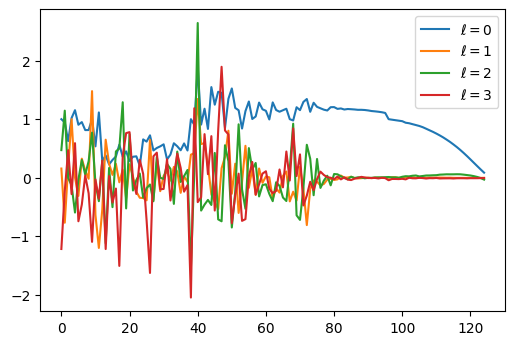

In [13]:
plt.figure(dpi = 100)
for i in range(4):
    plt.plot(q_ell[i], label = f'$\ell = {i}$')
plt.legend()

In [14]:
Q_ell = np.copy(q_ell)
# for i in range(len(rmin)):
#     if(i == 0):
#         Q_ell[0,int(N_r[:i].sum()):int(N_r[:(i+1)].sum())] *= 1./Q_ell[0,0]
#     else:
#         Q_ell[0,int(N_r[:i].sum()):int(N_r[:(i+1)].sum())] *= ( 2*Q_ell[0,int(N_r[:i].sum())-1] 
#                                                                 - Q_ell[0,int(N_r[:i].sum())-2] ) / Q_ell[0,int(N_r[:i].sum())] 

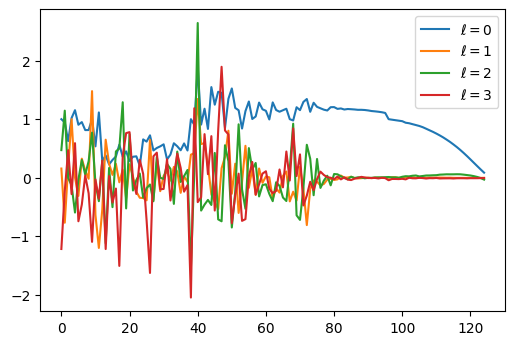

In [15]:
plt.figure(dpi = 100)
for i in range(4):
    plt.plot(Q_ell[i], label = f'$\ell = {i}$')
plt.legend()

### Normalize the higher $\ell$ multipoles by the same factor used for $Q_0$

In [16]:
for i in range(len(rmin)):
    for j in range(1,N_ell):
        Q_ell[j,int(N_r[:i].sum()):int(N_r[:(i+1)].sum())] = ( q_ell[j,int(N_r[:i].sum()):int(N_r[:(i+1)].sum())] / q_ell[0,int(N_r[:i].sum())] )*Q_ell[0,int(N_r[:i].sum())]

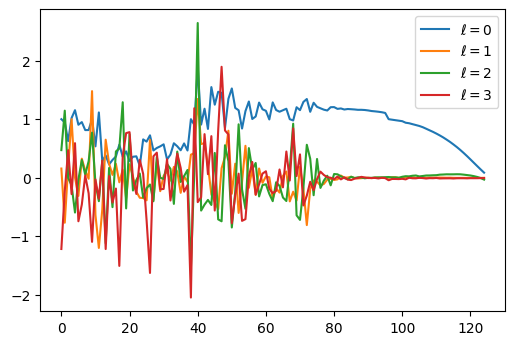

In [17]:
plt.figure(dpi = 100)
for i in range(4):
    plt.plot(Q_ell[i], label = f'$\ell = {i}$')
plt.legend()

#### For low $r$, the estimates of $Q_\ell$ can get noisy; therefore, when $Q_\ell<0$ for $r<10$ we set them to zero again

In [18]:
for i in range(4):
    w = np.where((Q_ell[i]<0)&(r_centers<10))
    if(len(w[0])!=0):
        Q_ell[i,:w[0][-1]] = 0

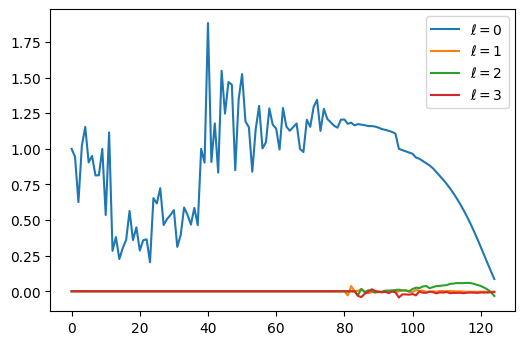

In [19]:
plt.figure(dpi = 100)
for i in range(4):
    plt.plot(Q_ell[i], label = f'$\ell = {i}$')
plt.legend()

#### Interpolate $Q_\ell$ to a logspaced vector, and apply a gaussian filter to make things more regular

In [20]:
# Interpolate Q_ell into a logspaced r so that it works well with FFTLog
r_interp = np.logspace(-2, np.log10(r_centers.max()), len(r_centers))
Q_interp = np.zeros((4, len(r_centers)))

for i in range(4):
    Q_interp[i] = np.interp(r_interp, r_centers, Q_ell[i])

In [21]:
w = np.where(Q_interp[0]>=1)
w

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 22, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 90, 91, 92]),)

In [22]:
Q_interp[0,:w[0][-1]] = 1

In [23]:
for i in range(4):
    Q_interp[i,:] = gaussian_filter(Q_interp[i,:], 3)

if(all_multipoles==False):
    ell_index = np.arange(0,N_ell,1)
    ell       = 2*ell_index
if(all_multipoles==True):
    ell_index = np.arange(0,N_ell,1)
    ell       = ell_index

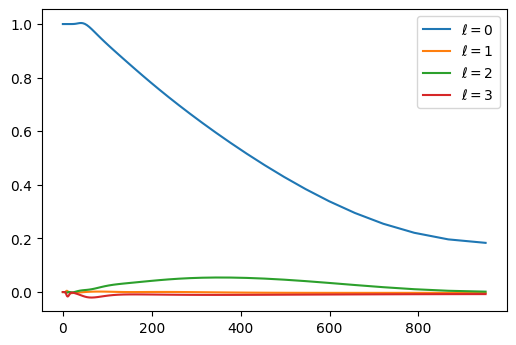

In [24]:
plt.figure(dpi = 100)
for i in range(4):
    plt.plot(r_interp, Q_interp[i], label = f'$\ell = {i}$')
plt.legend()

### Save the results

In [25]:
np.savetxt(f"Q_ell/r_centers-L{L0}.dat", r_interp)
np.savetxt(f"Q_ell/Q_ell-L{L0}.dat", Q_interp)

In [26]:
r_interp = np.loadtxt(f"Q_ell/r_centers-L{L0}.dat")
Q_interp = np.loadtxt(f"Q_ell/Q_ell-L{L0}.dat")
r_interp.shape, Q_interp.shape

((125,), (4, 125))

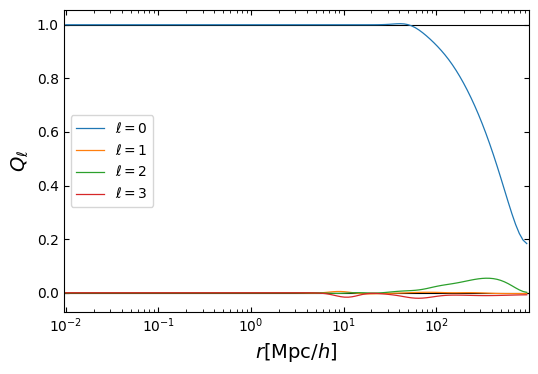

In [27]:
fig, ax = plt.subplots(dpi = 100)

ax.set_xscale('log')
ax.set_yscale('linear')

ax.set_xlabel('$r[$Mpc$/h]$', fontsize=14)
ax.set_ylabel('$Q_{\ell}$', fontsize=14)

for i in range(4):
    ax.plot(r_interp, Q_interp[i], label = f'$\ell = {i}$', linewidth=0.9)

ax.set_xlim(r_interp[0]*0.95, r_interp[-1]*1.05)

ax.hlines(0, 0.001, 10**3, linewidth=0.8, color='k')
ax.hlines(1, 0.001, 10**3, linewidth=0.8, color='k')

ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)

ax.legend()

plt.savefig(f'Q_ell/L0{L0}-Q_ell.pdf', bbox_inches='tight')

In [28]:
#Esse mcfit xi2P faz a deconvolução da (4.5)
k_ell, W0_temp = mcfit.xi2P(r_interp, l = 0)(Q_interp[0,:])
k_ell, W2_temp = mcfit.xi2P(r_interp, l = 2)(Q_interp[1,:])
k_ell, W4_temp = mcfit.xi2P(r_interp, l = 4)(Q_interp[2,:])
k_ell, W6_temp = mcfit.xi2P(r_interp, l = 6)(Q_interp[3,:])

#NOrmalização
W0_W1 = W0_temp/np.max(W0_temp)
W2_W1 = W2_temp/np.max(W2_temp)
W4_W1 = W4_temp/np.max(W4_temp)
W6_W1 = W6_temp/np.max(W6_temp)

/usr/local/lib/python3.8/dist-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/usr/local/lib/python3.8/dist-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [29]:
Wls = np.zeros(( 5, W0_W1.shape[0] ))
Wls[0] = k_ell
Wls[1] = W0_W1
Wls[2] = W2_W1
Wls[3] = W4_W1
Wls[4] = W6_W1

In [30]:
np.savetxt(f'Q_ell/L0{L0}-Wls.dat', Wls.T)

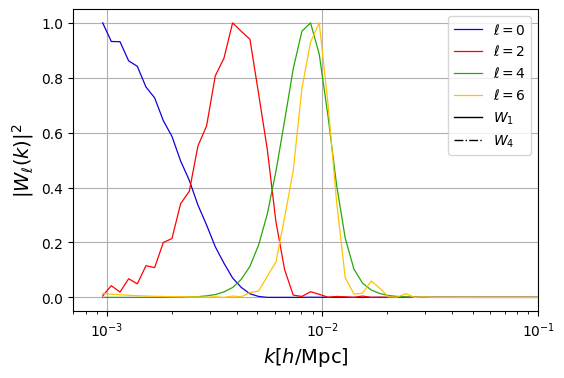

In [31]:
fig, ax = plt.subplots(dpi = 100)

ax.set_xscale('log')
# ax.set_yscale('log')

ax.plot(k_ell, np.abs(W0_W1)**2, color='#1000DA', linewidth=0.9, label=r'$\ell=0$')
ax.plot(k_ell, np.abs(W2_W1)**2, color='#FF0000', linewidth=0.9, label=r'$\ell=2$')
ax.plot(k_ell, np.abs(W4_W1)**2, color='#26A905', linewidth=0.9, label=r'$\ell=4$')
ax.plot(k_ell, np.abs(W6_W1)**2, color='#FFC300', linewidth=0.9, label=r'$\ell=6$')

ax.plot(np.zeros(10), np.zeros(10), color='k', linewidth=1, label='$W_1$')
ax.plot(np.zeros(10), np.zeros(10), color='k', linewidth=1, linestyle='-.', label='$W_4$')

ax.set_xlim(7e-4,1e-1)

ax.set_xlabel('$k[h/$Mpc$]$', fontsize=14)
ax.set_ylabel('$|W_\ell(k)|^2$', fontsize=14)

ax.legend()

ax.grid()

plt.savefig(f'Q_ell/L0{L0}-W_sq.pdf', bbox_inches='tight')

### Convolve them with this window function

In [32]:
%%time

rsd_pars = theory.rsd_params(b1 = np.asarray([1.0]), 
                             sigma_tot = np.asarray([300]))
redshift = np.asarray([1.0])

k_conv, Pk_conv = theory.convolved_multipoles(rsd_pars, 
                                              cosmo, redshift, 
                                              1, r_centers, 
                                              Q_interp) # Theoretical Spectrum convolved with survey window function

Time elapsed for CAMB + I/O: 1.1779215335845947
CPU times: user 124 ms, sys: 60 µs, total: 124 ms
Wall time: 1.3 s


/usr/local/lib/python3.8/dist-packages/mcfit/mcfit.py:157: UserWarning: input must be log-spaced
  warnings.warn("input must be log-spaced")
/usr/local/lib/python3.8/dist-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/usr/local/lib/python3.8/dist-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


### Compute original multipoles for comparison

In [33]:
Pk_dict = theory.power_spectrum(cosmo, 1, redshift, 1e-4, 1e1)

M_dict = theory.pk_multipoles_gauss(rsd_pars, cosmo, redshift, 1, 
                                    kmin = 1e-4, kmax = 1e1, 
                                    Nk = len(k_conv), k = Pk_dict['k'])

P_mono = Pk_dict['Pk_'+str(redshift[0])]*M_dict['mono'][0][0]
P_quad = Pk_dict['Pk_'+str(redshift[0])]*M_dict['quad'][0][0]
P_hexa = Pk_dict['Pk_'+str(redshift[0])]*M_dict['hexa'][0][0]

Time elapsed for CAMB + I/O: 0.9712622165679932


In [34]:
#Theoretical spectra
P_theoretical = np.zeros( ( 4, P_mono.shape[0] ) )
P_theoretical[0] = Pk_dict['k']
P_theoretical[1] = P_mono
P_theoretical[2] = P_quad
P_theoretical[3] = P_hexa

In [35]:
np.savetxt(f'Q_ell/L0{L0}-theoretical_spectra.dat', P_theoretical.T)

In [36]:
#Convolved spectra
P_convolved = np.zeros( ( 3, k_conv.shape[0] ) )
P_convolved[0] = k_conv
P_convolved[1] = Pk_conv[0]['P0_z1.0']
P_convolved[2] = Pk_conv[0]['P2_z1.0']

In [37]:
np.savetxt(f'Q_ell/L0{L0}-convolved_spectra.dat', P_convolved.T)

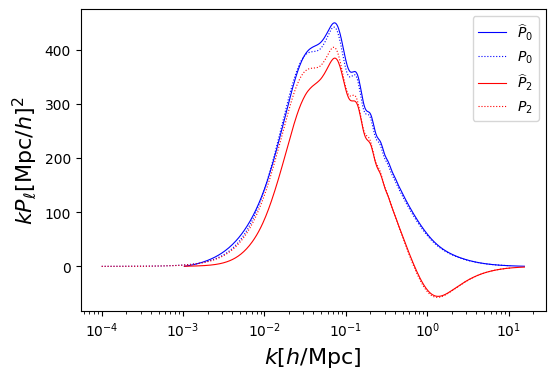

In [38]:
fig, ax = plt.subplots(dpi = 100)

ax.set_xscale('log')

ax.plot(k_conv, k_conv*Pk_conv[0]['P0_z1.0'], color='b', label='$\widehat{P}_0$', linewidth=0.8)
ax.plot(Pk_dict['k'], Pk_dict['k']*P_mono, color='b', linestyle=':', linewidth=0.8, label='$P_0$')

ax.plot(k_conv, k_conv*Pk_conv[0]['P2_z1.0'], color='r', label='$\widehat{P}_2$', linewidth=0.8)
ax.plot(Pk_dict['k'], Pk_dict['k']*P_quad, color='r', linestyle=':', linewidth=0.8, label='$P_2$')

ax.set_xlabel('$k[h/$Mpc$]$', fontsize=16)
ax.set_ylabel('$kP_\ell[$Mpc$/h]^2$', fontsize=16)

ax.legend()

plt.savefig(f'Q_ell/L0{L0}-kP_ell.pdf', bbox_inches='tight')

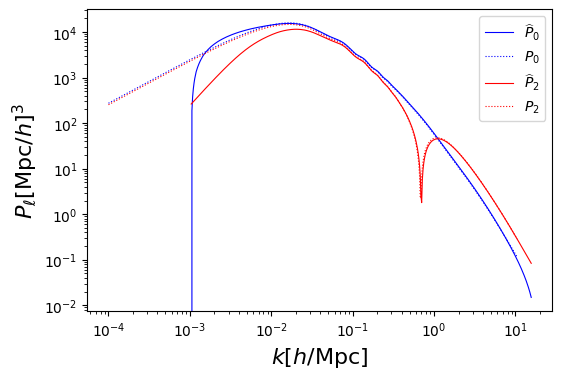

In [39]:
fig, ax = plt.subplots(dpi = 100)

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(k_conv, Pk_conv[0]['P0_z1.0'], color='b', label='$\widehat{P}_0$', linewidth=0.8)
ax.plot(Pk_dict['k'], P_mono, color='b', linestyle=':', linewidth=0.8, label='$P_0$')

ax.plot(k_conv, np.abs(Pk_conv[0]['P2_z1.0']), color='r', label='$\widehat{P}_2$', linewidth=0.8)
ax.plot(Pk_dict['k'], np.abs(P_quad), color='r', linestyle=':', linewidth=0.8, label='$P_2$')

ax.set_xlabel('$k[h/$Mpc$]$', fontsize = 16)
ax.set_ylabel('$P_\ell[$Mpc$/h]^3$', fontsize = 16)

ax.legend()

plt.savefig(f'Q_ell/L0{L0}-P_ell.pdf', bbox_inches='tight')